# MÔ HÌNH ANN DỰ ĐOÁN SUY TIM

Mô hình sử dụng mạng neural nhân tạo để dự đoán khả năng tử vong của bệnh nhân suy tim dựa trên các thông số lâm sàng.

## GIỚI THIỆU

Suy tim là một tình trạng nghiêm trọng trong đó tim không thể bơm đủ máu để đáp ứng nhu cầu của cơ thể. Dự đoán khả năng tử vong của bệnh nhân suy tim có thể giúp các bác sĩ phát triển kế hoạch điều trị phù hợp.

https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

## 1. IMPORT THƯ VIỆN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import callbacks
from matplotlib.patches import Rectangle

# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED'] = '42'

# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

## 2. TẢI DỮ LIỆU

In [2]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Giải thích các cột dữ liệu:

- **age**: Tuổi của bệnh nhân (năm)
- **anaemia**: Giảm hồng cầu hay không (0: không, 1: có)
- **creatinine_phosphokinase**: Mức CPK enzyme trong máu (mcg/L)
- **diabetes**: Bệnh nhân có bị tiểu đường hay không (0: không, 1: có)
- **ejection_fraction**: Tỷ lệ phần trăm máu rời khỏi tim mỗi khi co bóp (%)
- **high_blood_pressure**: Bệnh nhân có bị cao huyết áp hay không (0: không, 1: có)
- **platelets**: Số lượng tiểu cầu trong máu (kiloplatelets/mL)
- **serum_creatinine**: Mức serum creatinine trong máu (mg/dL)
- **serum_sodium**: Mức serum sodium trong máu (mEq/L)
- **sex**: Giới tính (0: nữ, 1: nam)
- **smoking**: Bệnh nhân có hút thuốc hay không (0: không, 1: có)
- **time**: Thời gian theo dõi (ngày)
- **DEATH_EVENT**: Bệnh nhân có tử vong trong thời gian theo dõi không (0: không, 1: có) - Biến mục tiêu

In [3]:
# Hiển thị thông tin dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


## 3. PHÂN TÍCH DỮ LIỆU

C:\Users\thanh\AppData\Local\Temp\ipykernel_21232\2618871860.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data["DEATH_EVENT"], palette=cols)


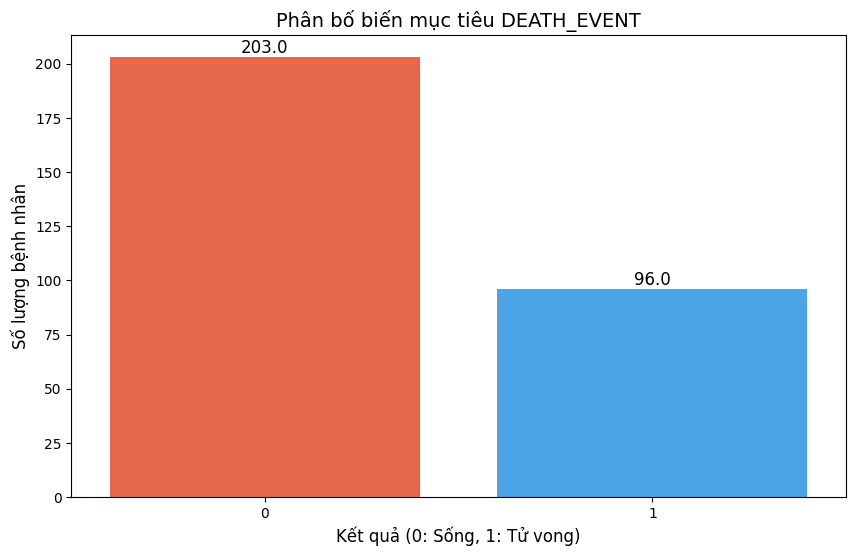

In [4]:
# Đầu tiên, đánh giá biến mục tiêu để xem dữ liệu có bị mất cân bằng không
cols = ["#FF5733", "#33A8FF"]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data["DEATH_EVENT"], palette=cols)
plt.title("Phân bố biến mục tiêu DEATH_EVENT", fontsize=14)
plt.xlabel("Kết quả (0: Sống, 1: Tử vong)", fontsize=12)
plt.ylabel("Số lượng bệnh nhân", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.show()

Biểu đồ trên cho thấy phân bố của biến mục tiêu DEATH_EVENT:
- Cột (0): Số bệnh nhân sống sót sau thời gian theo dõi
- Cột (1): Số bệnh nhân tử vong trong thời gian theo dõi

Dữ liệu hơi mất cân bằng, với số lượng bệnh nhân sống sót nhiều hơn so với số bệnh nhân tử vong. Điều này cần được xem xét khi đánh giá hiệu suất mô hình.

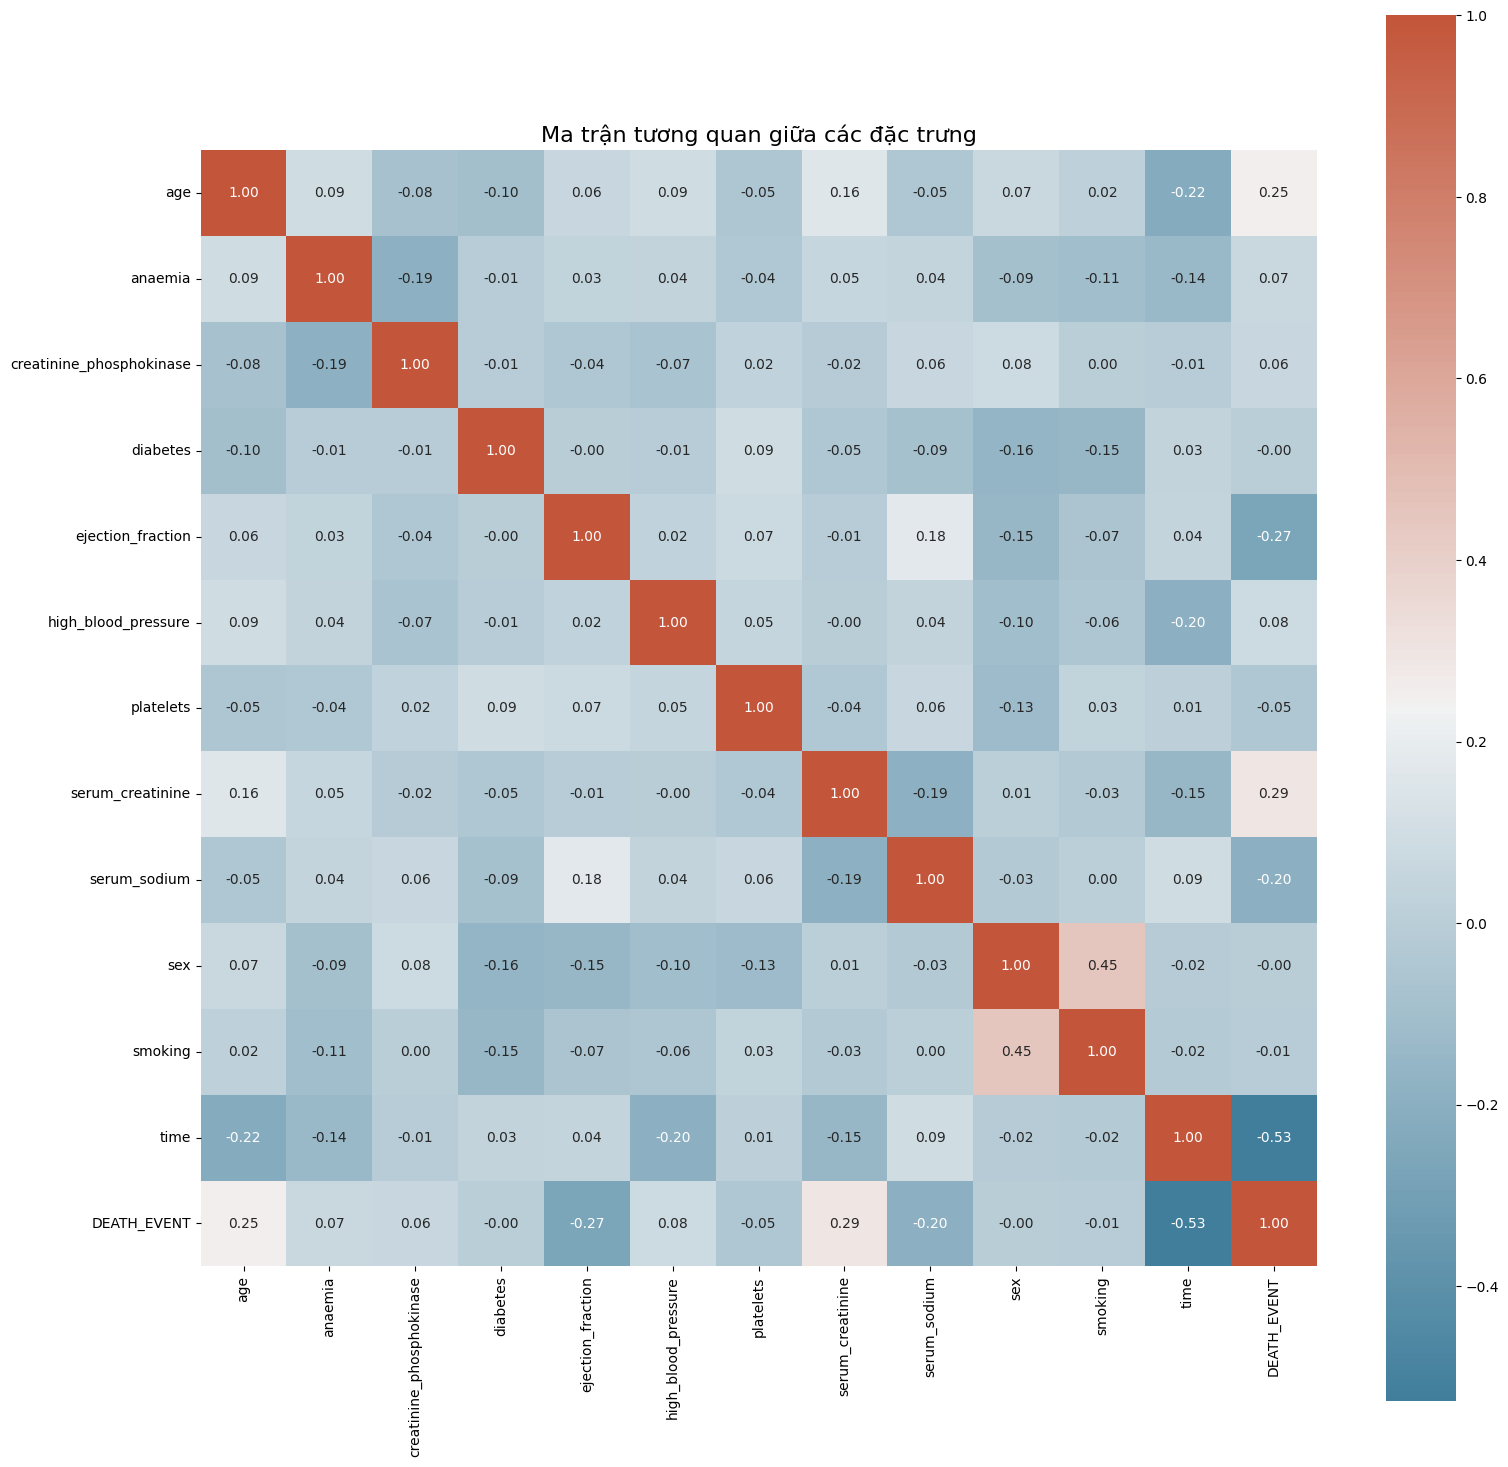

In [5]:
# Kiểm tra ma trận tương quan giữa các đặc trưng
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corrmat = data.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')
plt.title("Ma trận tương quan giữa các đặc trưng", fontsize=16)
plt.show()

Ma trận tương quan cho thấy mức độ tương quan giữa các đặc trưng trong dữ liệu:
- Biến mục tiêu DEATH_EVENT:

    - Có tương quan dương cao với `serum_creatinine` (0.29) và `age` (0.25), nghĩa là mức serum_creatinine cao hơn và tuổi cao hơn có liên quan đến nguy cơ tử vong cao hơn.
    - Có tương quan âm mạnh với `time` (-0.53) và `ejection_fraction` (-0.27), nghĩa là thời gian theo dõi dài hơn và phân suất tống máu cao hơn có liên quan đến khả năng sống sót cao hơn.

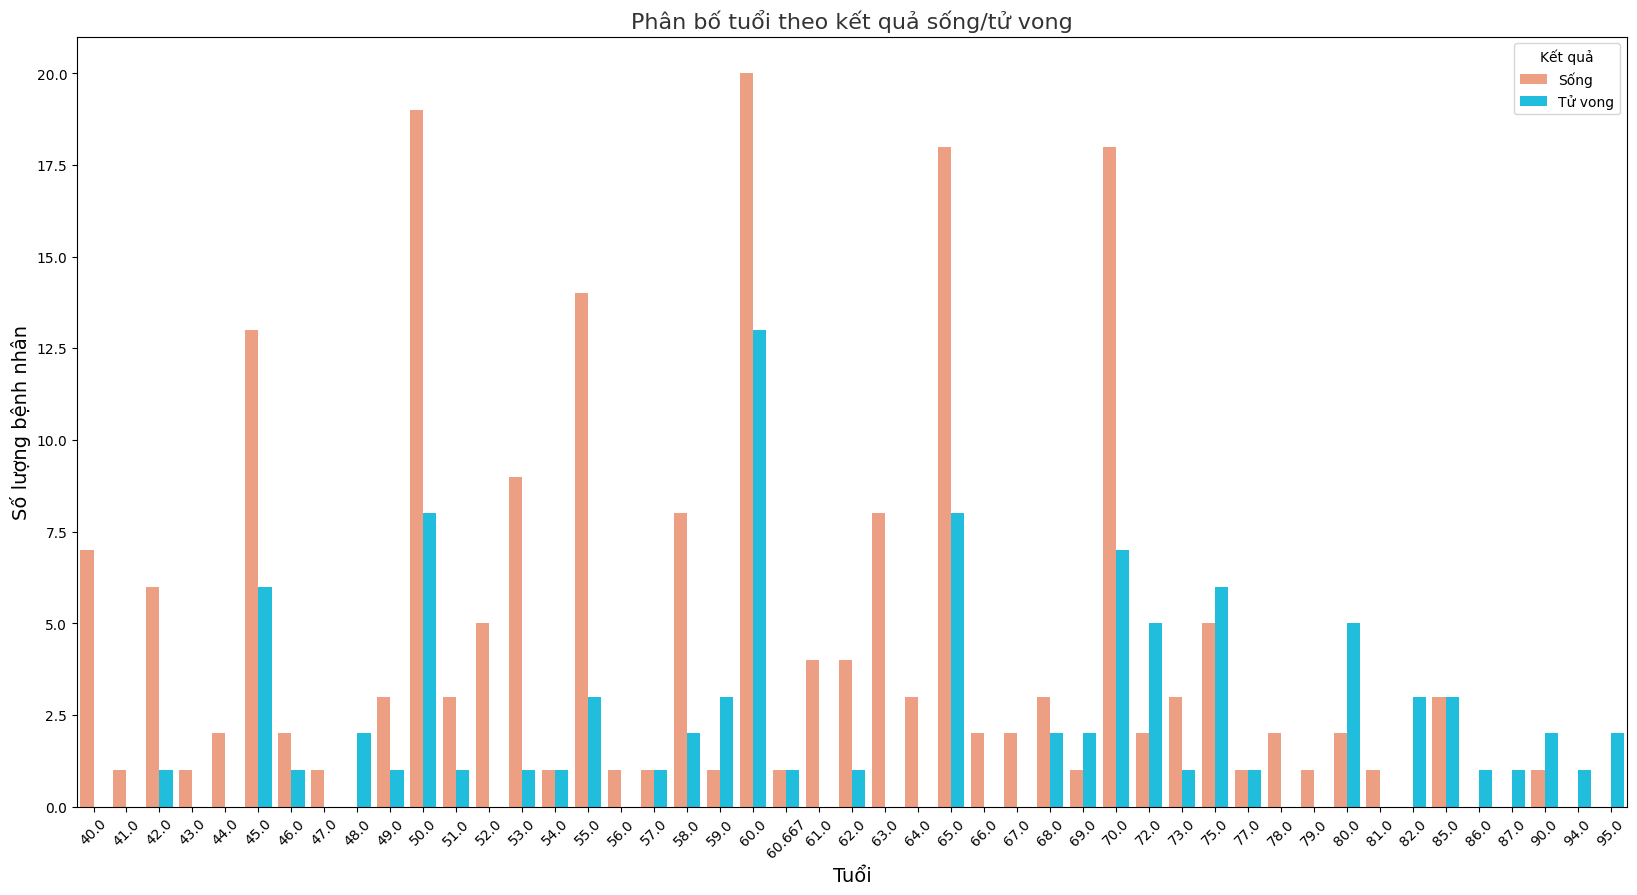

In [6]:
# Đánh giá phân bố tuổi của bệnh nhân
plt.figure(figsize=(20, 10))
age_cols = ["#FF9671", "#00D2FC"]
ax = sns.countplot(x=data['age'], data=data, hue="DEATH_EVENT", palette=age_cols)
ax.set_title("Phân bố tuổi theo kết quả sống/tử vong", fontsize=16, color="#333333")
plt.xlabel("Tuổi", fontsize=14)
plt.ylabel("Số lượng bệnh nhân", fontsize=14)
plt.legend(title="Kết quả", labels=["Sống", "Tử vong"])
plt.xticks(rotation=45)
plt.show()

Biểu đồ thể hiện phân bố tuổi của bệnh nhân theo kết quả sống/tử vong:
- Cột màu cam: Bệnh nhân sống sót sau thời gian theo dõi.
- Cột màu xanh: Bệnh nhân tử vong trong thời gian theo dõi.

Quan sát:
- Phần lớn bệnh nhân tập trung ở độ tuổi trung niên và cao tuổi (từ 45 đến 70).
- Ở các nhóm tuổi cao hơn (trên 72), tỷ lệ tử vong cao hơn so với tỷ lệ sống sót. Điều này cho thấy tuổi tác là một yếu tố nguy cơ quan trọng đối với tử vong do suy tim.

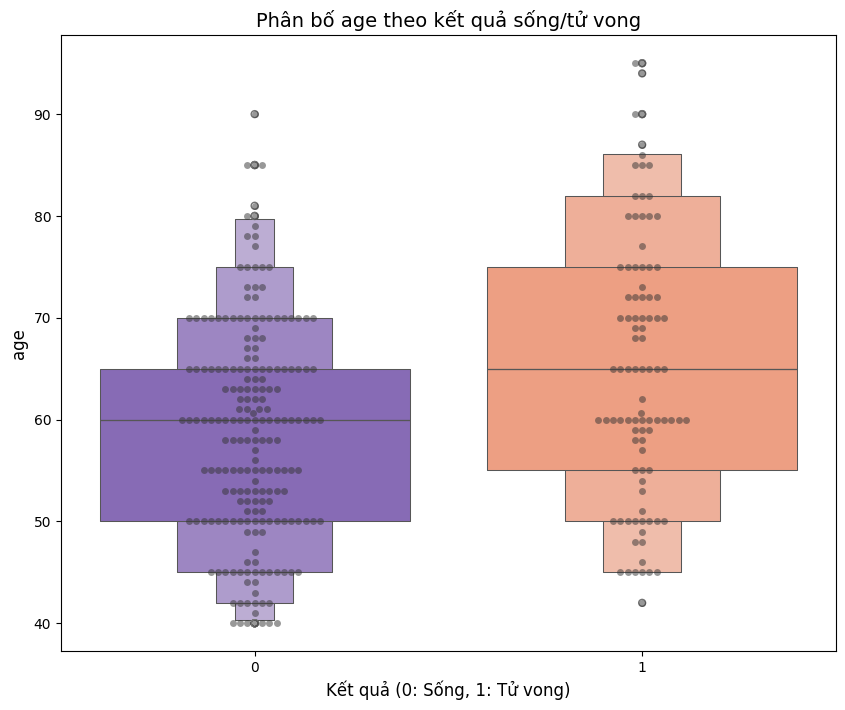

C:\Users\thanh\AppData\Roaming\Python\Python312\site-packages\seaborn\categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


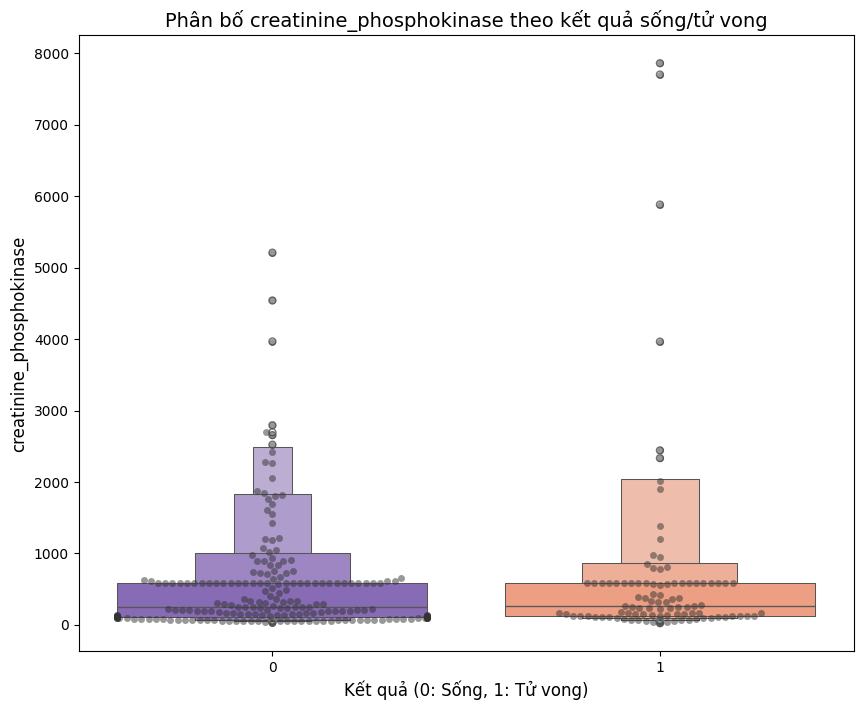

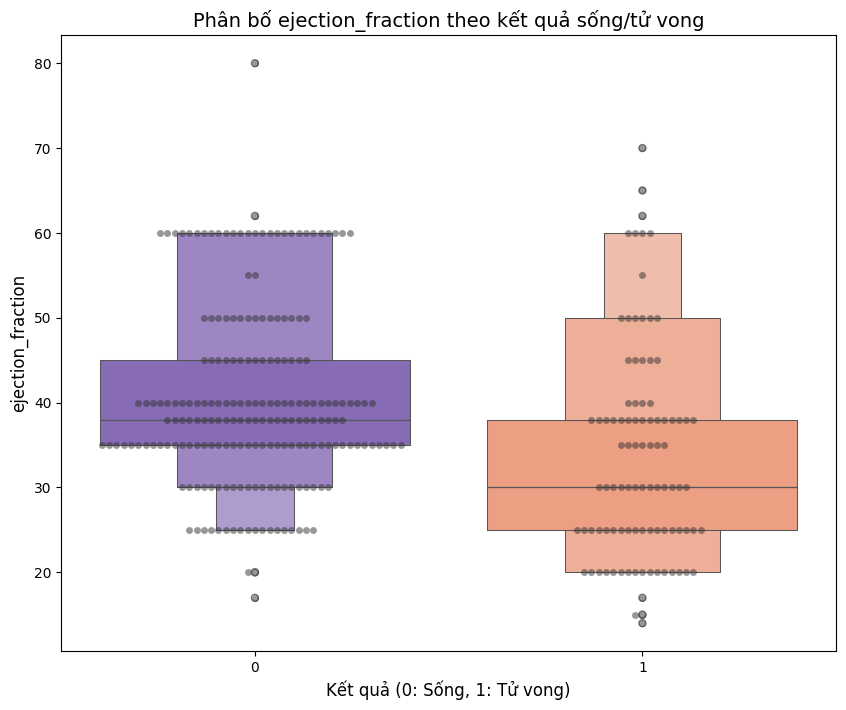

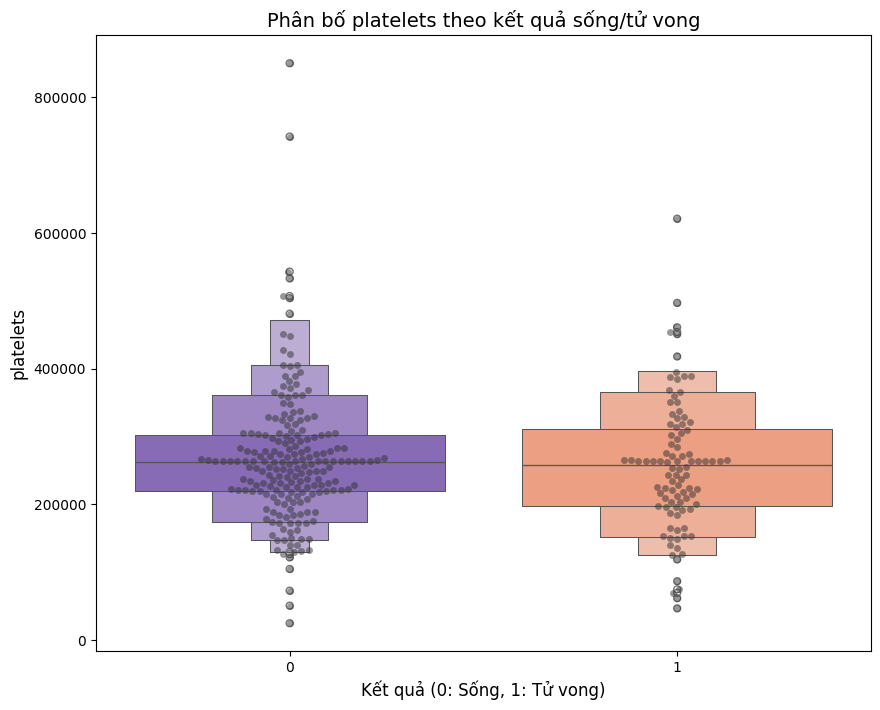

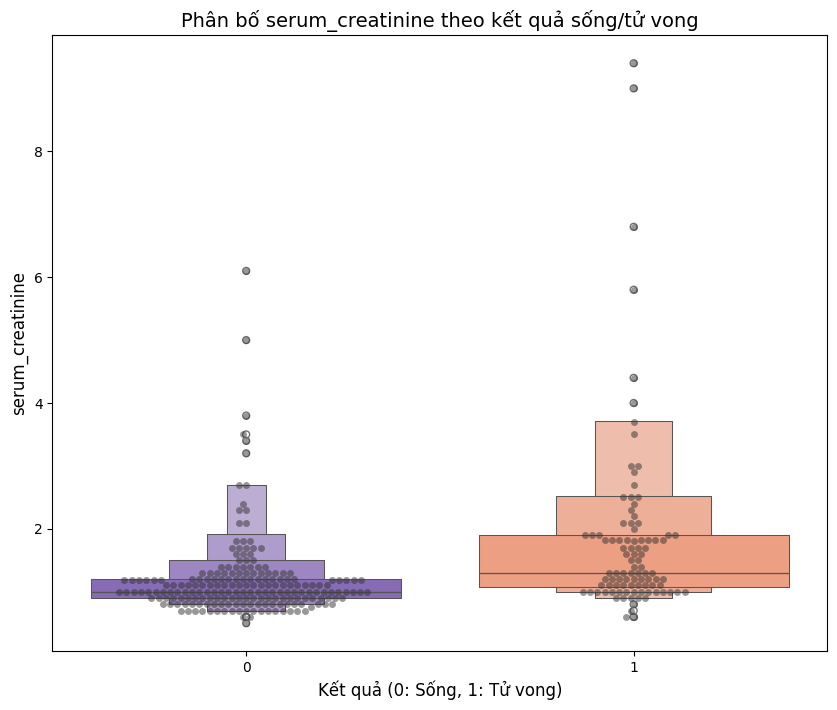

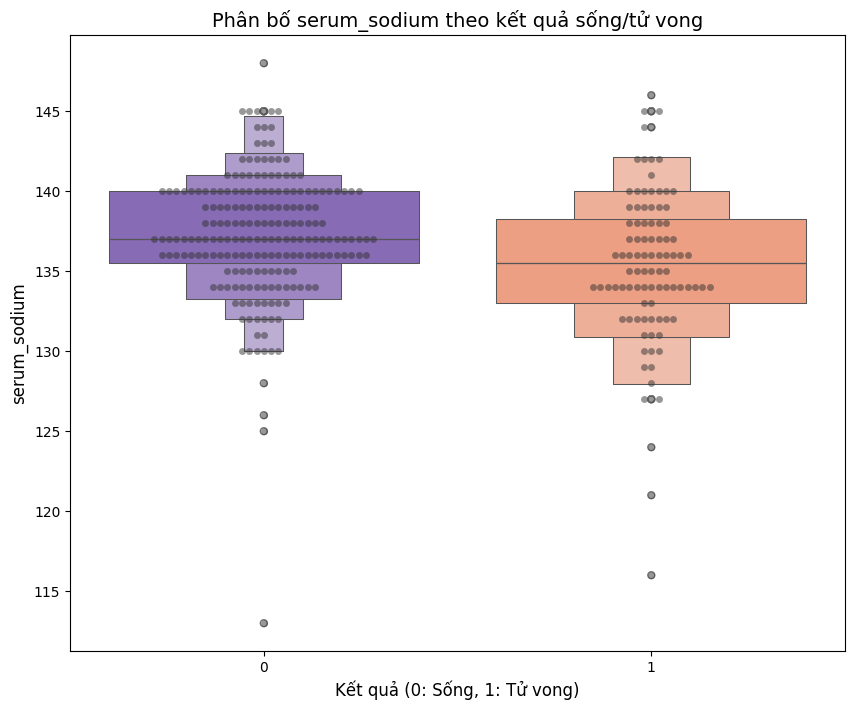

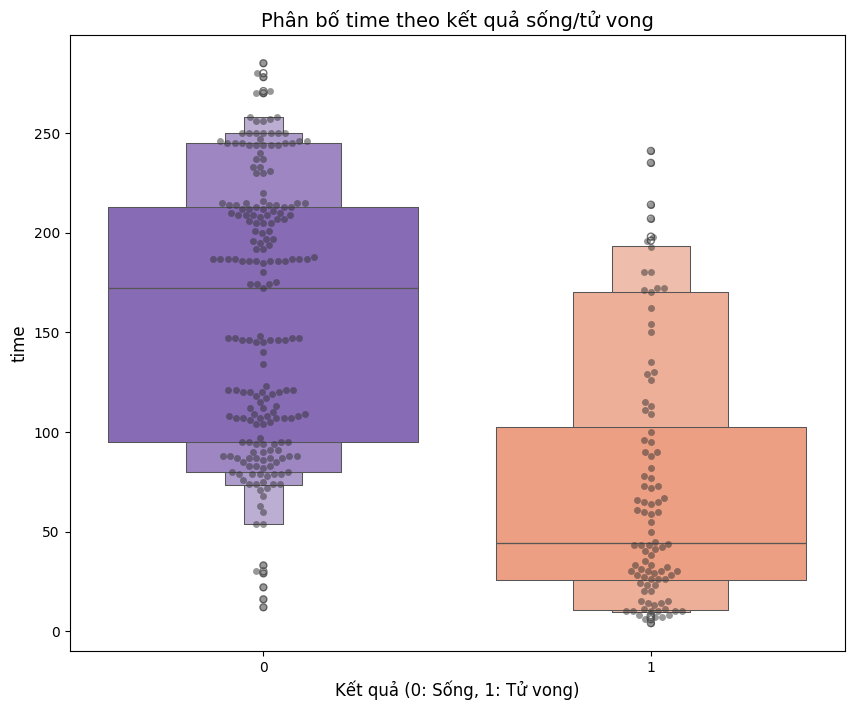

In [7]:
# Biểu đồ boxen và swarm cho các đặc trưng không phải nhị phân
feature = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
new_cols = ["#845EC2", "#FF9671"]

for i in feature:
    plt.figure(figsize=(10, 8))
    sns.swarmplot(x=data["DEATH_EVENT"], y=data[i], color="#333333", alpha=0.5)
 
    sns.boxenplot(x=data["DEATH_EVENT"], y=data[i], hue=data["DEATH_EVENT"], palette=new_cols, legend=False)
    plt.title(f"Phân bố {i} theo kết quả sống/tử vong", fontsize=14)
    plt.xlabel("Kết quả (0: Sống, 1: Tử vong)", fontsize=12)
    plt.ylabel(i, fontsize=12)
    plt.show()

**Biểu đồ boxen (màu tím và cam)**: Thể hiện phân bố thống kê bao gồm trung vị, các tứ phân vị và các giá trị ngoại lai. Tương tự như boxplot nhưng hiển thị nhiều thông tin hơn.
**Biểu đồ swarm (các điểm đen)**: Hiển thị vị trí của từng điểm dữ liệu riêng lẻ, thể hiện rõ mật độ và sự phân bố thực tế.

 - **`age`**: Nhóm tử vong có độ tuổi trung bình và trung vị cao hơn nhóm sống sót.

 - **`creatinine_phosphokinase`**: Nhóm tử vong nhiều giá trị ngoại lai rất cao so với nhóm sống sót. Điều này cho thấy mức CPK cực cao có thể liên quan đến tử vong.

 - **`ejection_fraction`**: Nhóm sống sót có phân suất tống máu cao hơn nhóm tử vong.

 - **`platelets`**: Phân bố số lượng tiểu cầu khá tương đồng giữa hai nhóm. Đặc trưng này có ít khả năng phân biệt hơn.


 - **`serum_creatinine`**: Nhóm tử vong có mức serum_creatinine cao hơn và phân bố rộng hơn (nhiều giá trị ngoại lai cao) so với nhóm sống sót.

  - **`serum_sodium`**: Nhóm tử vong có mức serum_sodium (trung vị) thấp hơn so với nhóm sống sót. Mức natri thấp (hyponatremia) cũng là một dấu hiệu dự đoán xấu.

 - **`time`**: Nhóm sống sót có thời gian theo dõi dài hơn đáng kể so với nhóm tử vong.

 -  Cho thấy các đặc trưng này có khả năng phân biệt giữa hai nhóm kết quả.

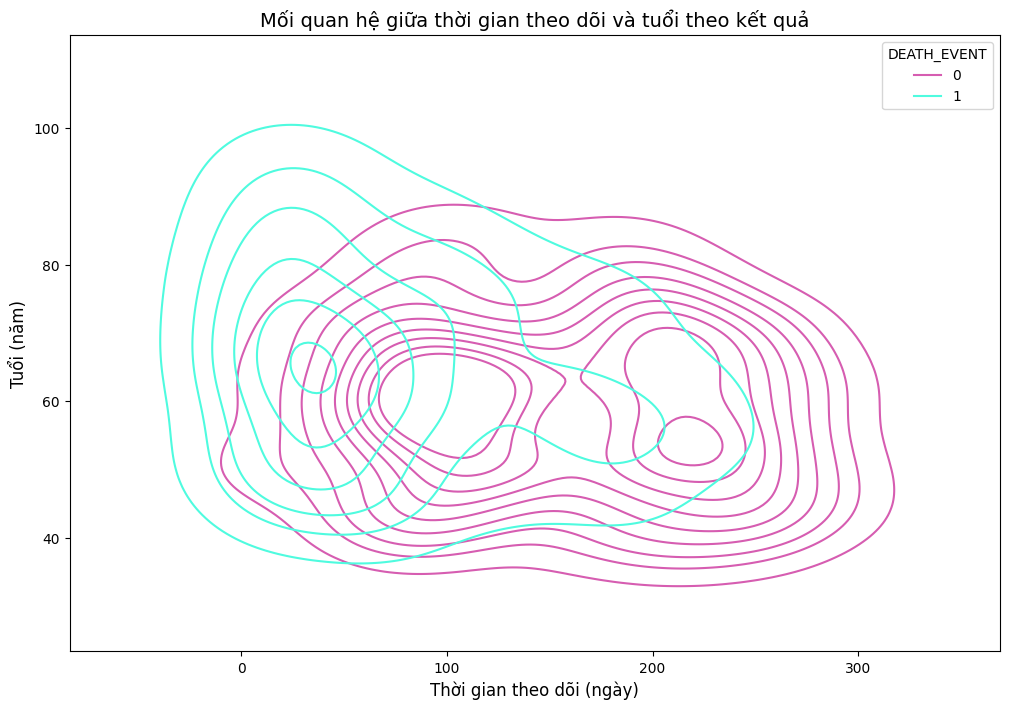

In [8]:
# Biểu đồ mật độ xác suất 2 chiều cho thời gian và tuổi
plt.figure(figsize=(12, 8))
new_kde_cols = ["#D65DB1", "#4FFBDF"] 
sns.kdeplot(x=data["time"], y=data["age"], hue=data["DEATH_EVENT"], palette=new_kde_cols)
plt.title("Mối quan hệ giữa thời gian theo dõi và tuổi theo kết quả", fontsize=14)
plt.xlabel("Thời gian theo dõi (ngày)", fontsize=12)
plt.ylabel("Tuổi (năm)", fontsize=12)
plt.show()

**Giải thích biểu đồ mật độ xác suất 2 chiều:**

- Màu hồng: Biểu diễn phân bố của nhóm bệnh nhân sống sót
- Màu xanh: Biểu diễn phân bố của nhóm bệnh nhân tử vong

   - **Nhóm Sống**: Tập trung chủ yếu ở khu vực có `time` dài hơn, trải dài trên nhiều độ tuổi.

    - **Nhóm Tử vong**: Tập trung chủ yếu ở khu vực có `time` ngắn hơn, và có xu hướng tập trung ở các độ tuổi cao hơn.
    
 - Biểu đồ này thể hiện mối quan hệ giữa thời gian theo dõi, tuổi và kết quả tử vong. Bệnh nhân sống sót thường được theo dõi lâu hơn, trong khi tử vong thường xảy ra sớm hơn, đặc biệt ở người lớn tuổi."


In [9]:
# Thống kê mô tả của dữ liệu
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


- **count**: Số dòng không có giá trị thiếu
- **mean**: Giá trị trung bình
- **std**: Độ lệch chuẩn
- **min**: Giá trị nhỏ nhất
- **25%**: Phân vị thứ Q1, giá trị mà 25% dữ liệu nhỏ hơn nó
- **50%**: Phân vị thứ Q2 hay trung vị, giá trị mà 50% dữ liệu nhỏ hơn nó
- **75%**: Phân vị thứ Q3, giá trị mà 75% dữ liệu nhỏ hơn nó.
- **max**: Giá trị lớn nhất

## 4. TIỀN XỬ LÝ DỮ LIỆU

In [10]:
# Tách đặc trưng (X) và biến mục tiêu (y)
X = data.drop(["DEATH_EVENT"], axis=1)  # Tất cả các cột trừ DEATH_EVENT là đặc trưng
y = data["DEATH_EVENT"]  # DEATH_EVENT là biến mục tiêu

In [11]:
# Chuẩn hóa các đặc trưng bằng StandardScaler
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df = s_scaler.fit_transform(X) 
X_df = pd.DataFrame(X_df, columns=col_names)

X_df.describe()  # Mô tả sau khi chuẩn hóa

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,2.990000e+02,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02
mean,5.703353e-16,1.009969e-16,0.000000,9.060014e-17,-3.267546e-17,0.000000,7.723291e-17,1.425838e-16,-8.673849e-16,-8.911489e-18,-1.188199e-17,-1.901118e-16
std,1.001676e+00,1.001676e+00,1.001676,1.001676e+00,1.001676e+00,1.001676,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00
min,-1.754448e+00,-8.711048e-01,-0.576918,-8.475794e-01,-2.038387e+00,-0.735688,-2.440155e+00,-8.655094e-01,-5.363206e+00,-1.359272e+00,-6.876819e-01,-1.629502e+00
25%,-8.281242e-01,-8.711048e-01,-0.480393,-8.475794e-01,-6.841802e-01,-0.735688,-5.208700e-01,-4.782047e-01,-5.959961e-01,-1.359272e+00,-6.876819e-01,-7.389995e-01
50%,-7.022315e-02,-8.711048e-01,-0.342574,-8.475794e-01,-7.076750e-03,-0.735688,-1.390846e-02,-2.845524e-01,8.503384e-02,7.356882e-01,-6.876819e-01,-1.969543e-01
75%,7.718891e-01,1.147968e+00,0.000166,1.179830e+00,5.853888e-01,1.359272,4.111199e-01,5.926150e-03,7.660638e-01,7.356882e-01,1.454161e+00,9.387595e-01
max,2.877170e+00,1.147968e+00,7.514640,1.179830e+00,3.547716e+00,1.359272,6.008180e+00,7.752020e+00,2.582144e+00,7.356882e-01,1.454161e+00,1.997038e+00


- Sau chuẩn hóa: mean gần 0, std gần 1

C:\Users\thanh\AppData\Local\Temp\ipykernel_21232\170521301.py:4: UserWarning: 
The palette list has fewer values (5) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data=X_df, palette=new_color_palette)


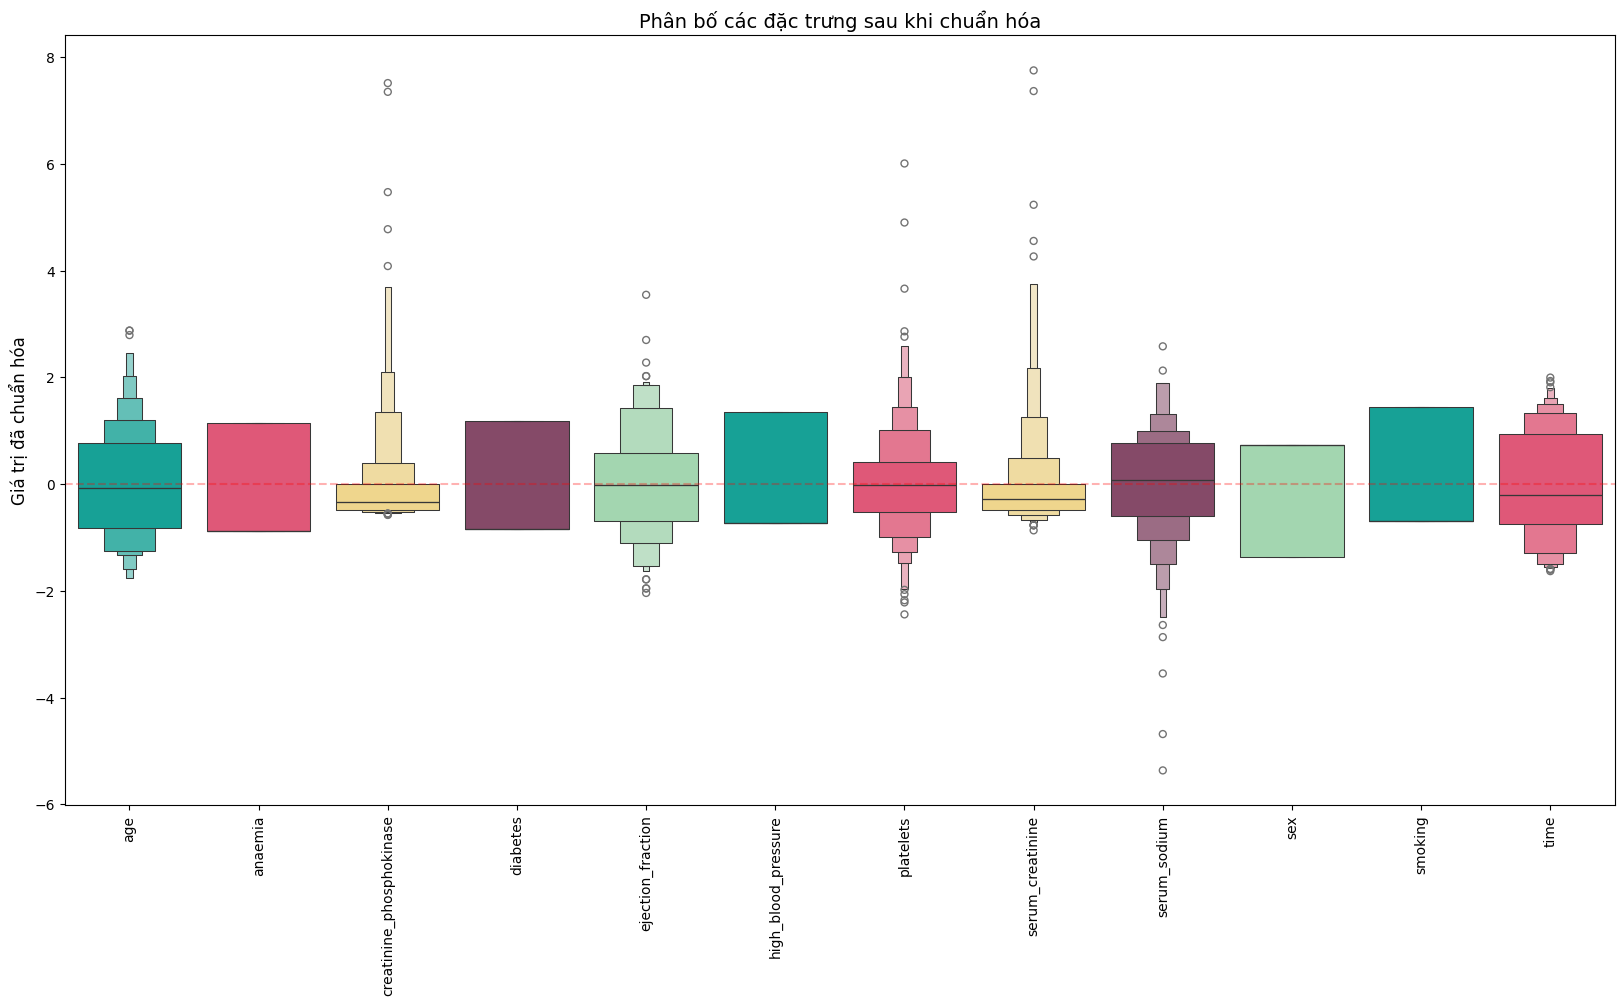

In [12]:
# Quan sát các đặc trưng đã được chuẩn hóa
new_color_palette = ["#00B8A9", "#F6416C", "#FFDE7D", "#8F4068", "#9BDEAC"]
plt.figure(figsize=(20, 10))
sns.boxenplot(data=X_df, palette=new_color_palette)
plt.title("Phân bố các đặc trưng sau khi chuẩn hóa", fontsize=14)
plt.xticks(rotation=90)
plt.ylabel("Giá trị đã chuẩn hóa", fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()

Biểu đồ trên thể hiện phân bố của các đặc trưng sau khi chuẩn hóa:
- Mỗi màu biểu thị một đặc trưng khác nhau
- Đường nét đứt màu đỏ biểu thị giá trị 0 (mean sau chuẩn hóa)
- Hầu hết các đặc trưng đều có phân bố xung quanh 0

In [13]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.25, random_state=7)
print(f"Kích thước tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]} mẫu")

Kích thước tập huấn luyện: 224 mẫu
Kích thước tập kiểm tra: 75 mẫu


## 5. XÂY DỰNG MÔ HÌNH

In [14]:
# Thiết lập early stopping tránh overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # lượng thay đổi tối thiểu để được tính là cải thiện
    patience=20,  # số epoch đợi trước khi dừng nếu không có cải thiện
    restore_best_weights=True)  # khôi phục trọng số tốt nhất

# Khởi tạo mô hình
model = Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(12,)),  # 12 là số đặc trưng đầu vào

    Dense(units=16, kernel_initializer='uniform', activation='relu'),
    Dense(units=8, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(units=4, kernel_initializer='uniform', activation='relu'),
    Dropout(0.5),
    Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Tóm tắt cấu trúc mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

### Trực quan hóa kiến trúc mạng neural

Tự động cập nhật khi thay đổi (thêm/xóa) các lớp trong mô hình ở trên.

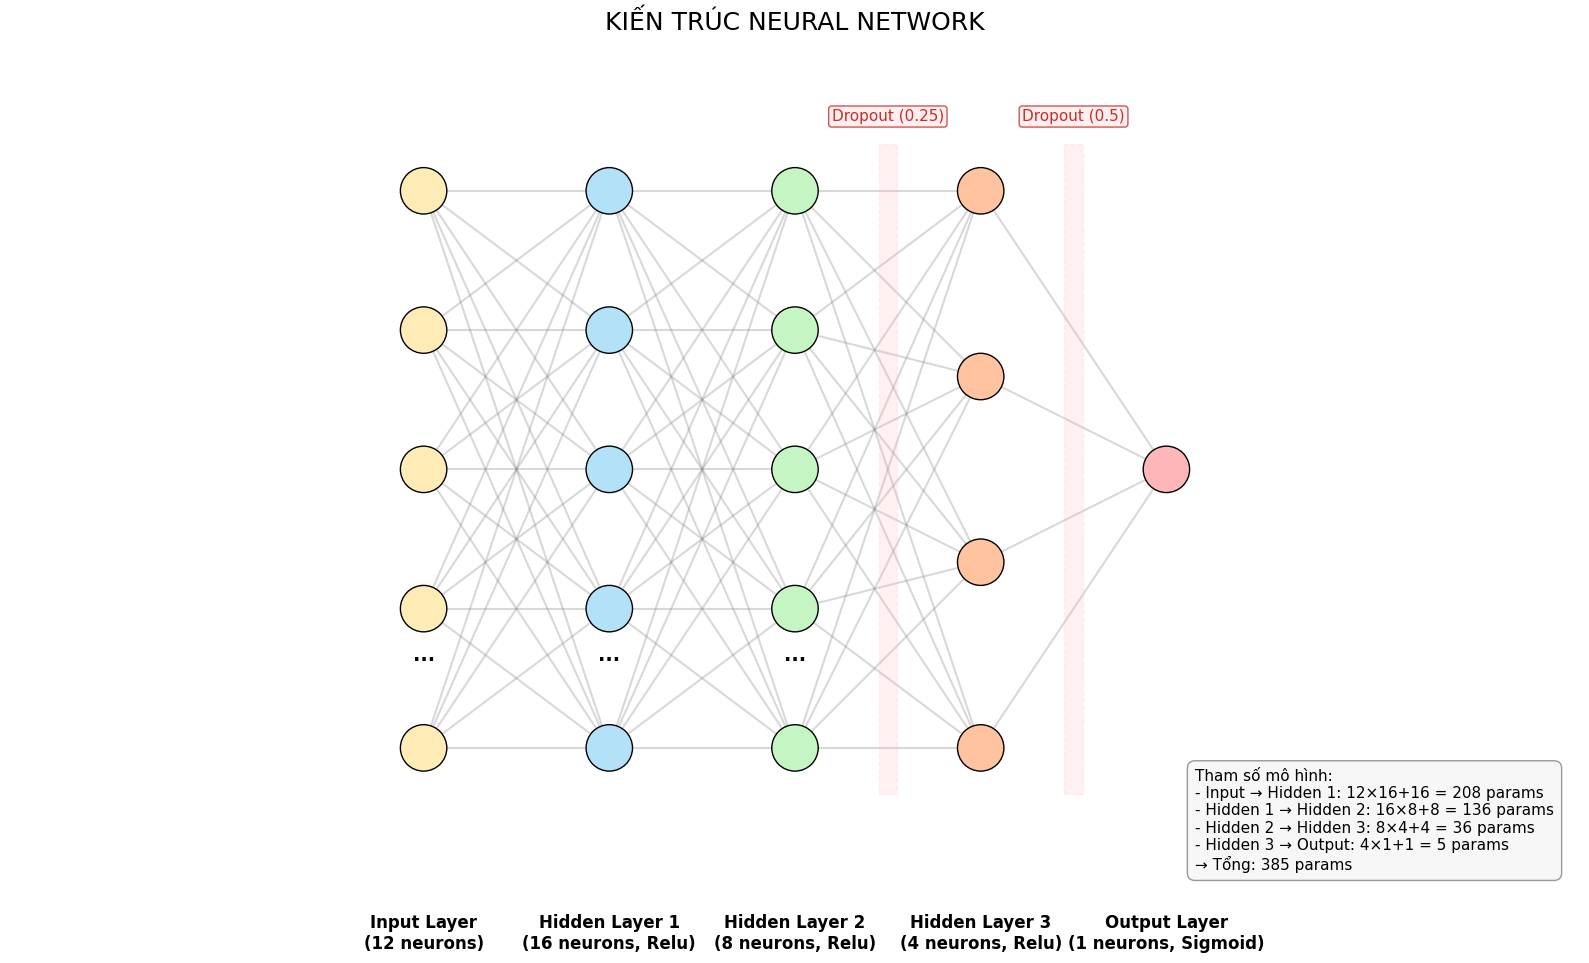

In [15]:
def visualize_network_architecture(model):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Rectangle

    # Trích xuất cấu trúc mô hình trực tiếp từ model đã tạo
    layer_sizes = []
    layer_types = []
    dropout_rates = []

    # Lấy thông tin về các lớp từ mô hình
    for layer in model.layers:
        if 'dense' in layer.name:
            layer_sizes.append(layer.units)
            layer_types.append('dense')
        elif 'dropout' in layer.name:
            dropout_rates.append(layer.rate)
            layer_types.append('dropout')

    # Xác định số lượng đầu vào từ input_shape của model
    input_dim = model.input_shape[1]

    # Tạo cấu trúc lớp dựa trên mô hình thực tế
    hidden_neurons = []
    for i, layer_type in enumerate(layer_types):
        if layer_type == 'dense':
            hidden_neurons.append(layer_sizes[len(hidden_neurons)])

    # Danh sách các lớp để vẽ (bao gồm Input layer)
    layer_neurons = [input_dim] + hidden_neurons

    # Danh sách thông tin dropout
    dropout_info = []
    current_dropout_idx = 0
    current_layer_idx = 0

    for i, layer_type in enumerate(layer_types):
        if layer_type == 'dropout':
            dropout_info.append({
                'after_layer': current_layer_idx,
                'rate': dropout_rates[current_dropout_idx]
            })
            current_dropout_idx += 1
        else:
            current_layer_idx += 1

    # Số tham số cho từng lớp
    param_counts = []
    layer_connections = []

    for i in range(len(layer_neurons) - 1):
        params = layer_neurons[i] * layer_neurons[i+1] + layer_neurons[i+1]  # weights + biases
        param_counts.append(params)
        layer_connections.append(f"{layer_neurons[i]}×{layer_neurons[i+1]}+{layer_neurons[i+1]}")

    total_params = sum(param_counts)

    layer_colors_base = ['#FFEBB5', '#B3E1F7', '#C5F5C2', '#FFC3A0', '#FFB6B9', '#D4A5FF', '#A5D4FF', '#FFA5D4']
    layer_colors = (layer_colors_base * ((len(layer_neurons) // len(layer_colors_base)) + 1))[:len(layer_neurons)]
    
    # Xác định hàm kích hoạt cho các lớp
    layer_activations = ['']  # Input layer không có activation
    
    # Lấy thông tin activation từ các lớp Dense trong mô hình
    activation_idx = 0
    for layer in model.layers:
        if hasattr(layer, 'activation') and 'dense' in layer.name:
            # Lấy tên hàm kích hoạt, viết hoa chữ cái đầu
            act_name = layer.activation.__name__.capitalize()
            if act_name == 'Linear': act_name = 'Linear'
            layer_activations.append(act_name)
            activation_idx += 1
    
    layer_names = ['Input Layer'] + [f'Hidden Layer {i+1}' for i in range(len(layer_neurons) - 2)] + ['Output Layer']

    layers = []
    for i, (neurons, name, color, activation) in enumerate(zip(layer_neurons, layer_names, layer_colors, layer_activations)):
        layers.append({
            'name': name, 
            'nodes': neurons, 
            'color': color, 
            'activation': activation
        })

    plt.figure(figsize=(16, 10))

    # Vẽ kiến trúc mạng neural
    n_layers = len(layers)
    layer_positions = np.linspace(0.1, 0.9, n_layers)
    max_nodes = max([layer['nodes'] for layer in layers])
    node_radius = min(0.025, 0.8 / (2 * max_nodes))

    # Vẽ các nút và kết nối
    node_positions = {}

    # Vẽ từng lớp
    for i, (layer_pos, layer) in enumerate(zip(layer_positions, layers)):
        # Vẽ tiêu đề lớp
        title = f"{layer['name']}\n({layer['nodes']} neurons"
        if layer['activation']:
            title += f", {layer['activation']}"
        title += ")"
        plt.text(layer_pos, 0.00, title, ha='center', va='center', fontsize=12, fontweight='bold')
        
        # Vẽ các nút
        node_positions[i] = []
        
        if i == n_layers - 1:
            output_y = 0.5
            circle = plt.Circle((layer_pos, output_y), node_radius, color=layer['color'], ec='black', zorder=4)
            plt.gca().add_patch(circle)
            node_positions[i].append((layer_pos, output_y))
        elif layer['nodes'] <= 5:  # Nếu ≤ 5 nút, vẽ tất cả
            node_y_positions = np.linspace(0.8, 0.2, layer['nodes'])
            for j, y_pos in enumerate(node_y_positions):
                circle = plt.Circle((layer_pos, y_pos), node_radius, color=layer['color'], ec='black', zorder=4)
                plt.gca().add_patch(circle)
                node_positions[i].append((layer_pos, y_pos))
        else:  # Nếu > 5 nút, vẽ 5 nút và dấu '...'
            node_y_positions = np.linspace(0.8, 0.35, 4)  # 4 nút trên
            for j, y_pos in enumerate(node_y_positions):
                circle = plt.Circle((layer_pos, y_pos), node_radius, color=layer['color'], ec='black', zorder=4)
                plt.gca().add_patch(circle)
                node_positions[i].append((layer_pos, y_pos))
                
            # Dấu ...
            plt.text(layer_pos, 0.3, '...', ha='center', va='center', fontsize=14, fontweight='bold')
            
            # Nút cuối cùng
            circle = plt.Circle((layer_pos, 0.2), node_radius, color=layer['color'], ec='black', zorder=4)
            plt.gca().add_patch(circle)
            node_positions[i].append((layer_pos, 0.2))

    # Vẽ kết nối giữa các lớp
    for i in range(n_layers - 1):
        for pos1 in node_positions[i]:
            for pos2 in node_positions[i+1]:
                line = plt.Line2D([pos1[0], pos2[0]], [pos1[1], pos2[1]], color='gray', alpha=0.3, zorder=1)
                plt.gca().add_line(line)

    # Vẽ lớp dropout giữa các lớp
    for dropout in dropout_info:
        layer_idx = dropout['after_layer']
        if layer_idx < n_layers - 1:
            # Vị trí x giữa hai lớp
            x_start = layer_positions[layer_idx] 
            x_end = layer_positions[layer_idx + 1]
            x_middle = (x_start + x_end) / 2
            
            # Vẽ vùng dropout
            dropout_width = (x_end - x_start) * 0.1
            rect_x = x_middle - dropout_width/2
            rect_y = 0.15
            rect_height = 0.7
            
            rect = Rectangle((rect_x, rect_y), dropout_width, rect_height, 
                          alpha=0.2, color='#FFB6C1', fill=True, zorder=2, 
                          ec='#FFB6C1', linestyle='dashed', linewidth=1)
            plt.gca().add_patch(rect)
            
            # Thêm nhãn dropout
            plt.text(x_middle, rect_y + rect_height + 0.03, f"Dropout ({dropout['rate']})",
                    ha='center', va='center', fontsize=11, color='#C92C2C', 
                    bbox=dict(boxstyle="round,pad=0.2", fc='#FFECEC', ec='#C92C2C', alpha=0.8))

    plt.axis('equal')
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(-0.05, 1)

    plt.suptitle('KIẾN TRÚC NEURAL NETWORK', fontsize=18, y=0.98)

    # Khung giải thích tham số
    explanation_lines = ["Tham số mô hình:"]
    for i in range(len(param_counts)):
        layer_from = "Input" if i == 0 else f"Hidden {i}"
        layer_to = "Output" if i == len(param_counts) - 1 else f"Hidden {i+1}"
        explanation_lines.append(f"- {layer_from} → {layer_to}: {layer_connections[i]} = {param_counts[i]} params")
    explanation_lines.append(f"→ Tổng: {total_params} params")

    explanation_text = "\n".join(explanation_lines)
    plt.figtext(0.75, 0.12, explanation_text, fontsize=11, 
              bbox=dict(boxstyle="round,pad=0.5", fc='#F5F5F5', ec='gray', alpha=0.8))

    # Chú thích giữa các lớp
    bottom_text_parts = []
    for i, layer in enumerate(layers):
        if i == 0:
            bottom_text_parts.append(f"Input Layer ({layer['nodes']} neurons)")
        elif i == len(layers) - 1:
            activation_name = layer['activation'] if layer['activation'] else 'None'
            bottom_text_parts.append(f"Output Layer ({layer['nodes']} neuron, {activation_name})")
        else:
            activation_name = layer['activation'] if layer['activation'] else 'None'
            bottom_text_parts.append(f"Hidden Layer {i} ({layer['nodes']} neurons, {activation_name})")

    bottom_text = "       ".join(bottom_text_parts)  # Khoảng cách giữa các phần tử

    # Chú thích ngoài phạm vi  biểu đồ
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.subplots_adjust(bottom=0.1) 
    plt.show()

visualize_network_architecture(model)

In [16]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, batch_size=32, epochs=500, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6125 - loss: 0.6930 - val_accuracy: 0.6667 - val_loss: 0.6922
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6523 - loss: 0.6921 - val_accuracy: 0.6667 - val_loss: 0.6914
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6190 - loss: 0.6917 - val_accuracy: 0.6667 - val_loss: 0.6905
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6619 - loss: 0.6904 - val_accuracy: 0.6667 - val_loss: 0.6896
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6597 - loss: 0.6896 - val_accuracy: 0.6667 - val_loss: 0.6888
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6393 - loss: 0.6893 - val_accuracy: 0.6667 - val_loss: 0.6880
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6211 - loss: 0.6890 - val_accuracy: 0.6667 - val_loss: 0.6871
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6686 - loss: 0.6871 - val_accuracy: 0.6667 - val_loss:

In [17]:
model.summary()  # Hiển thị tóm tắt mô hình

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157 (4.52 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 772 (3.02 KB)

1. **Early Stopping**: Thiết lập cơ chế dừng sớm tránh overfitting. Huấn luyện sẽ dừng nếu sau 20 epoch không có cải thiện đáng kể (min_delta=0.001) về hiệu suất trên tập validation.

2. **Optimizer**: Adam là một thuật toán tối ưu hóa kết hợp ưu điểm của hai thuật toán phổ biến là RMSprop và Momentum, giúp tối ưu trọng số hiệu quả.

3. **Loss Function**: Binary Crossentropy là hàm mất mát phù hợp cho bài toán phân loại nhị phân.

4. **Batch Size**: 32 mẫu mỗi batch, giá trị phổ biến cân bằng giữa tốc độ và độ chính xác.

5. **Epochs**: Tối đa 500 epochs, nhưng early stopping có thể dừng sớm hơn nếu không có cải thiện.

6. **Validation Split**: 20% dữ liệu huấn luyện được dùng làm tập validation để đánh giá mô hình trong quá trình huấn luyện.

In [18]:
# Hiển thị độ chính xác trung bình trên tập validation
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('Độ chính xác trên tập validation', val_accuracy*100))


Độ chính xác trên tập validation: 77.88%


## Trực quan hóa quá trình huấn luyện

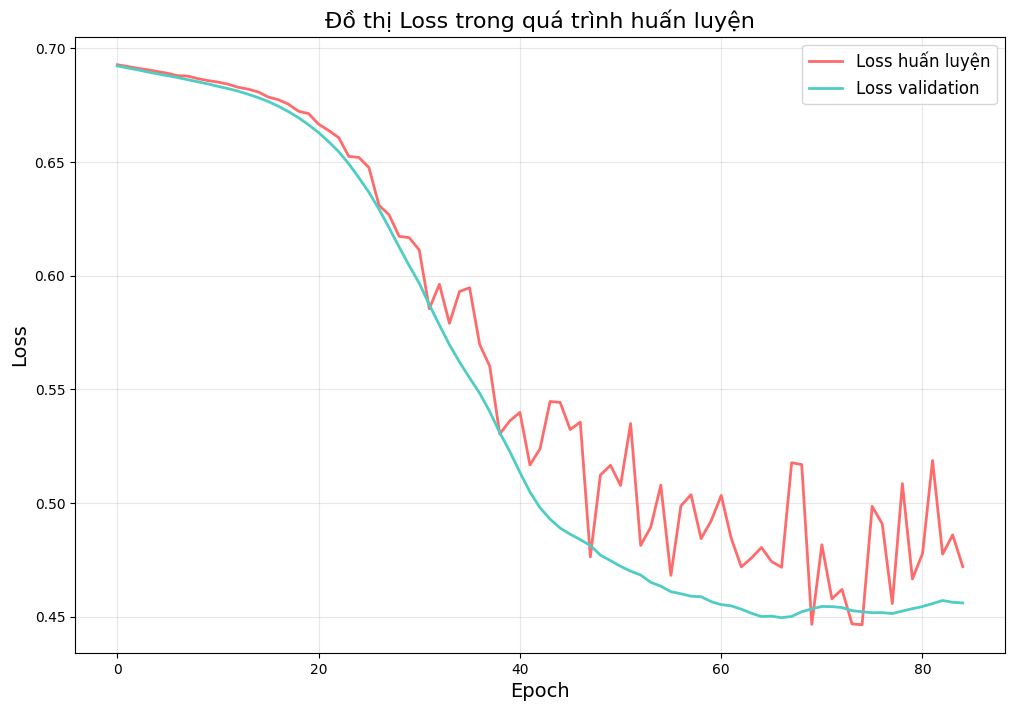

In [19]:
# Vẽ đồ thị loss trong quá trình huấn luyện
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 8))
plt.plot(history_df.loc[:, ['loss']], "#FF6B6B", linewidth=2, label='Loss huấn luyện')
plt.plot(history_df.loc[:, ['val_loss']], "#4ECDC4", linewidth=2, label='Loss validation')
plt.title('Đồ thị Loss trong quá trình huấn luyện', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

**Giải thích đồ thị Loss:**

- **Đường màu đỏ**: Loss trên tập huấn luyện, thể hiện mức độ khớp của mô hình với dữ liệu huấn luyện
- **Đường màu xanh**: Loss trên tập validation, thể hiện khả năng tổng quát hóa của mô hình

Lưu ý:
- Nếu cả hai đường giảm và tiến gần nhau: Mô hình đang học tốt
- Nếu loss trên tập huấn luyện tiếp tục giảm nhưng loss trên tập validation bắt đầu tăng: Mô hình đang bị overfitting
- Nếu cả hai đường giảm chậm và vẫn cao: Mô hình có thể bị underfitting

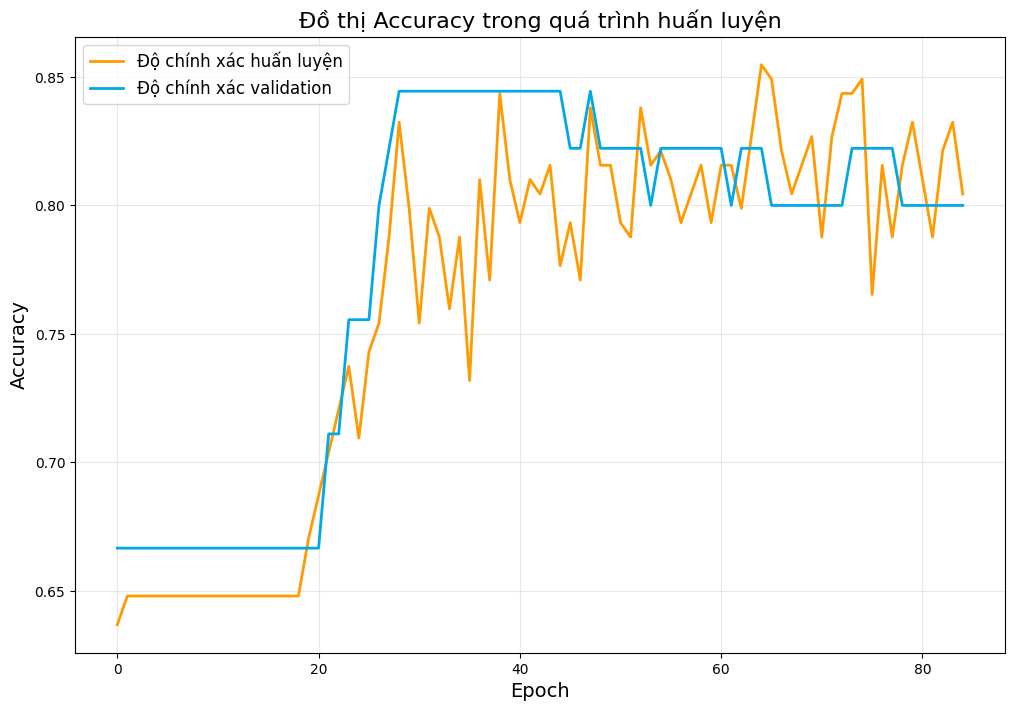

In [20]:
# Vẽ đồ thị accuracy trong quá trình huấn luyện
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 8))
plt.plot(history_df.loc[:, ['accuracy']], "#FF9A00", linewidth=2, label='Độ chính xác huấn luyện')
plt.plot(history_df.loc[:, ['val_accuracy']], "#00A8E8", linewidth=2, label='Độ chính xác validation')

plt.title('Đồ thị Accuracy trong quá trình huấn luyện', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

- Xác định thời điểm mô hình đạt hiệu suất tốt nhất và dừng huấn luyện
- **Overfitting**: Nếu đường accuracy tập train tiếp tục tăng cao trong khi đường accuracy validation đi ngang hoặc giảm là một dấu hiệu của overfitting. Khoảng cách lớn giữa hai đường này cho thấy mô hình hoạt động tốt trên dữ liệu đã biết nhưng kém hơn trên dữ liệu mới.

## 6. ĐÁNH GIÁ MÔ HÌNH

In [21]:
y_pred_prob = model.predict(X_test)

# Sử dụng ngưỡng thấp hơn để tối ưu hóa recall (có thể giảm precision)
threshold = 0.3
y_pred = (y_pred_prob > threshold).astype(int)  # Chuyển xác suất thành nhãn nhị phân

print(f"Hoàn thành dự đoán trên tập kiểm tra với ngưỡng {threshold}.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Hoàn thành dự đoán trên tập kiểm tra với ngưỡng 0.3.


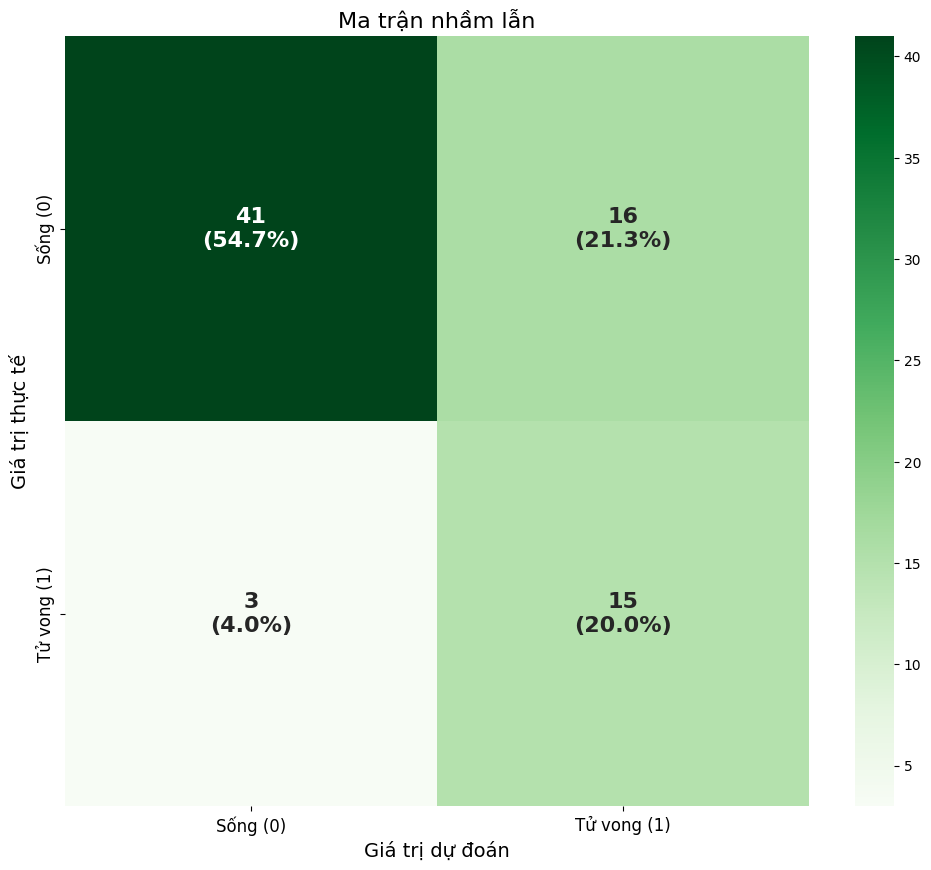

In [22]:
# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
cf_matrix = confusion_matrix(y_test, y_pred)

cmap2 = plt.cm.Greens

# Tính tỷ lệ phần trăm cho ma trận nhầm lẫn
group_percentages = cf_matrix / np.sum(cf_matrix) * 100

labels = [[f"{cf_matrix[i, j]}\n({group_percentages[i, j]:.1f}%)" for j in range(cf_matrix.shape[1])] for i in range(cf_matrix.shape[0])]

sns.heatmap(cf_matrix, cmap=cmap2, annot=labels, fmt="", annot_kws={'size': 16, 'fontweight': 'bold'})

plt.xlabel('Giá trị dự đoán', fontsize=14)
plt.ylabel('Giá trị thực tế', fontsize=14)
plt.title('Ma trận nhầm lẫn', fontsize=16)

tick_labels = ['Sống (0)', 'Tử vong (1)']
plt.xticks([0.5, 1.5], tick_labels, fontsize=12)
plt.yticks([0.5, 1.5], tick_labels, fontsize=12)

plt.show()

**Giải thích Ma trận nhầm lẫn (Confusion Matrix):**

- **True Positive (TP)**: Số bệnh nhân tử vong được dự đoán chính xác là tử vong
- **True Negative (TN)**: Số bệnh nhân sống được dự đoán chính xác là sống
- **False Positive (FP)**: Số bệnh nhân sống nhưng được dự đoán sai là tử vong (Lỗi loại I)
- **False Negative (FN)**: Số bệnh nhân tử vong nhưng được dự đoán sai là sống (Lỗi loại II)

Trong ngữ cảnh y tế, FN (bỏ sót những bệnh nhân có nguy cơ tử vong) thường được xem là nghiêm trọng hơn FP, vì điều này có thể dẫn đến việc không can thiệp kịp thời cho những bệnh nhân có nguy cơ cao.

In [23]:
print("BÁO CÁO PHÂN LOẠI:\n")
print(classification_report(y_test, y_pred, zero_division=1))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print("\nCÁC CHỈ SỐ HIỆU SUẤT CHI TIẾT:")
print(f"Độ chính xác (Accuracy): {accuracy:.4f}")
print(f"Độ chuẩn xác (Precision): {precision:.4f}")
print(f"Độ nhạy (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

BÁO CÁO PHÂN LOẠI:

              precision    recall  f1-score   support

           0       0.93      0.72      0.81        57
           1       0.48      0.83      0.61        18

    accuracy                           0.75        75
   macro avg       0.71      0.78      0.71        75
weighted avg       0.82      0.75      0.76        75


CÁC CHỈ SỐ HIỆU SUẤT CHI TIẾT:
Độ chính xác (Accuracy): 0.7467
Độ chuẩn xác (Precision): 0.4839
Độ nhạy (Recall): 0.8333
F1-Score: 0.6122


**Giải thích Các chỉ số hiệu suất:**

1. **Độ chính xác (Accuracy)**: Tỷ lệ dự đoán đúng trên tổng số mẫu. Công thức: (TP + TN) / (TP + TN + FP + FN)

2. **Độ chuẩn xác (Precision)**: Trong số các trường hợp được dự đoán là tử vong, có bao nhiêu thực sự tử vong. Công thức: TP / (TP + FP)
   - Precision cao: Mô hình ít đưa ra dự đoán dương tính giả (FP)

3. **Độ nhạy (Recall/Sensitivity)**: Trong số các trường hợp thực sự tử vong, có bao nhiêu được dự đoán đúng. Công thức: TP / (TP + FN)
   - Recall cao: Mô hình ít bỏ sót các trường hợp tử vong (FN)

4. **F1-Score**: Trung bình điều hòa của Precision và Recall. Công thức: 2 * (Precision * Recall) / (Precision + Recall)
   - F1-Score cân bằng giữa Precision và Recall, tác dụng khi dữ liệu mất cân bằng

Trong y tế, Recall được ưu tiên hơn vì giảm thiểu FN quan trọng hơn (không bỏ sót bệnh nhân có nguy cơ tử vong).